# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
 
# in principle, all of these imports should be simplified once this is a package
from openpathsampling.collectivevariable import CV_Function, CV_Volume, CV_MD_Function
from openpathsampling.snapshot import Snapshot
from openpathsampling.volume import CVRangeVolumePeriodic, VolumeFactory as vf
from openpathsampling.pathmover import PathMoverFactory as mf
from openpathsampling.ensemble import EnsembleFactory as ef
from openpathsampling.ensemble import (LengthEnsemble, SequentialEnsemble, AllOutXEnsemble,
                      AllInXEnsemble, PartInXEnsemble, PartOutXEnsemble)
from openpathsampling.storage import Storage
from openpathsampling.trajectory import Trajectory
from openpathsampling.pathsimulator import Bootstrapping
from openpathsampling.shooting import UniformSelector
from openpathsampling.pathmover import PathMover, SampleGeneratingMover
import simtk.unit as u

from openpathsampling.openmm_engine import OpenMMEngine

from openpathsampling.storage import Storage
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

Radians to Degree conversion

In [2]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [3]:
options = {
            'temperature' : 300.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 10,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
 }

In [4]:
engine = OpenMMEngine.auto(
                filename="trajectory.nc",
                template="../data/Alanine_solvated.pdb",
                options=options,
                mode='create'
                )

And save the storage in a separate variable for convenience

In [5]:
storage = engine.storage
paths.EngineGeneratingMover.engine = engine

In [6]:
storage.set_caching_mode('lowmemory')

Equilibrate

In [7]:
engine.current_snapshot = engine.template
engine.equilibrate(5)
engine.initialized = True

Save equilibrated snapshot with index 0

In [8]:
storage.save(engine.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [9]:
psi_atoms = [6,8,14,16]
psi = CV_MD_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = CV_MD_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

In [10]:
storage.save([psi, phi]);

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

In [11]:
stateA = CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0/degrees, 
    lambda_max=-30.0/degrees, 
    period_min=-180.0/degrees, 
    period_max=+180.0/degrees
)
stateB = CVRangeVolumePeriodic(psi, 100/degrees, 180/degrees, -180.0/degrees, +180.0/degrees)

Now do the same for a set of lambda ranges to produce nested volumes.

In [12]:
minima = map((1.0 / degrees).__mul__,
             [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])

maxima = map((1.0 / degrees).__mul__,
             [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = vf.CVRangeVolumePeriodicSet(psi, minima, maxima, -180.0/degrees, +180.0/degrees)

### Ensembles

Now do this automatically for all ensembles

In [13]:
interface0 = volume_set[0]
interface_set = ef.TISEnsembleSet(stateA, stateA | stateB, volume_set, psi)
for no, interface in enumerate(interface_set):
    # Give each interface a name
    interface.name = 'Interface '+str(no)
    # And save all of these
    storage.ensembles.save(interface)

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [14]:
first_traj_ensemble = SequentialEnsemble([
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA),
    (AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)) | LengthEnsemble(0),
    AllInXEnsemble(interface0) | LengthEnsemble(0),
    AllOutXEnsemble(interface0),
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA) & LengthEnsemble(1)
])

In [15]:
platform = engine.simulation.context.getPlatform()
print platform.getName()

OpenCL


### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [16]:
snapshot = storage.load(Snapshot, 0)
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

Show the length

In [17]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  80


And save the trajetory completely

In [18]:
storage.save(total_path);

In [19]:
len(psi.cache_dict.cache._cache)

80

In [20]:
len(psi.store_dict.cache._cache)

1

In [21]:
realtraj = list(total_path)

In [22]:
%%timeit
phi(total_path.lazy())

The slowest run took 462.76 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 412 µs per loop


In [24]:
%timeit phi(total_path)
print phi(total_path)

1000 loops, best of 3: 427 µs per loop
[-1.39990163 -1.43681943 -1.39648044 -1.32745719 -1.34587407 -1.34450018
 -1.2414459  -1.2580601  -1.10998118 -1.11002016 -1.06882894 -1.04053915
 -1.02314091 -1.01751208 -1.03253508 -1.07503164 -1.13288474 -1.19464493
 -1.31124866 -1.48470092 -1.5858947  -1.54324138 -1.57496274 -1.50559592
 -1.49481106 -1.53194964 -1.37715673 -1.37354434 -1.44028878 -1.35117137
 -1.36634791 -1.33927572 -1.29025018 -1.45475852 -1.43301272 -1.35556114
 -1.36934423 -1.12062764 -1.18839622 -1.16507113 -1.06602168 -1.05316114
 -1.13097882 -1.09223843 -1.11919713 -1.10574222 -1.10739207 -1.19150603
 -1.18349087 -1.39400363 -1.51379907 -1.44438136 -1.51810944 -1.37283123
 -1.25876594 -1.25715876 -1.22439981 -1.11907411 -1.11795568 -1.28427255
 -1.09491515 -1.09853172 -1.02605605 -1.0350455  -1.01573646 -0.93256909
 -0.94499272 -0.93674654 -0.84834433 -0.87945145 -0.88240242 -0.85949439
 -0.83157653 -1.0162257  -1.03960168 -0.94041598 -1.06828308 -1.13937187
 -1.3350898 

In [27]:
%time phi(total_path)

CPU times: user 712 µs, sys: 175 µs, total: 887 µs
Wall time: 770 µs


array([-1.39990163, -1.43681943, -1.39648044, -1.32745719, -1.34587407,
       -1.34450018, -1.2414459 , -1.2580601 , -1.10998118, -1.11002016,
       -1.06882894, -1.04053915, -1.02314091, -1.01751208, -1.03253508,
       -1.07503164, -1.13288474, -1.19464493, -1.31124866, -1.48470092,
       -1.5858947 , -1.54324138, -1.57496274, -1.50559592, -1.49481106,
       -1.53194964, -1.37715673, -1.37354434, -1.44028878, -1.35117137,
       -1.36634791, -1.33927572, -1.29025018, -1.45475852, -1.43301272,
       -1.35556114, -1.36934423, -1.12062764, -1.18839622, -1.16507113,
       -1.06602168, -1.05316114, -1.13097882, -1.09223843, -1.11919713,
       -1.10574222, -1.10739207, -1.19150603, -1.18349087, -1.39400363,
       -1.51379907, -1.44438136, -1.51810944, -1.37283123, -1.25876594,
       -1.25715876, -1.22439981, -1.11907411, -1.11795568, -1.28427255,
       -1.09491515, -1.09853172, -1.02605605, -1.0350455 , -1.01573646,
       -0.93256909, -0.94499272, -0.93674654, -0.84834433, -0.87

In [28]:
%%prun
storage.snapshots.all()

In [86]:
q = storage.snapshots.all()

In [85]:
%%timeit
phi(storage.snapshots.all())
# print len(storage.snapshots)

1000 loops, best of 3: 1.01 ms per loop


In [71]:
gen = (phi(x) for x in total_path)
%time list(gen)

CPU times: user 1.96 ms, sys: 451 µs, total: 2.41 ms
Wall time: 2.12 ms


[array(-1.3999016284942627, dtype=float32),
 array(-1.4497532844543457, dtype=float32),
 array(-1.3894202709197998, dtype=float32),
 array(-1.3655471801757812, dtype=float32),
 array(-1.282393455505371, dtype=float32),
 array(-1.2777804136276245, dtype=float32),
 array(-1.1443427801132202, dtype=float32),
 array(-1.1254745721817017, dtype=float32),
 array(-1.0132360458374023, dtype=float32),
 array(-0.9750471711158752, dtype=float32),
 array(-0.9443507194519043, dtype=float32),
 array(-1.0409181118011475, dtype=float32),
 array(-1.0025378465652466, dtype=float32),
 array(-0.983226478099823, dtype=float32),
 array(-1.0821844339370728, dtype=float32),
 array(-1.0921590328216553, dtype=float32),
 array(-1.2268948554992676, dtype=float32),
 array(-1.278991460800171, dtype=float32),
 array(-1.2923246622085571, dtype=float32),
 array(-1.2951316833496094, dtype=float32),
 array(-1.2971274852752686, dtype=float32),
 array(-1.2494984865188599, dtype=float32),
 array(-1.2976000308990479, dtype=f

In [77]:
%timeit phi(total_path.lazy())
print phi(total_path.lazy())

1000 loops, best of 3: 245 µs per loop
[-1.39990163 -1.44123173 -1.39491212 -1.38134289 -1.37729943 -1.38079464
 -1.2611953  -1.21364975 -1.16220319 -1.18332958 -1.13887239 -1.06178463
 -1.15137589 -0.98211831 -1.06553948 -1.1917305  -1.18414438 -1.27336514
 -1.30614722 -1.13393378 -1.20498121 -1.08810115 -1.13145435 -1.31610274
 -1.21216691 -1.25134051 -1.11288154 -1.03654468 -1.0737195  -1.09035659
 -1.1675818  -1.20827591 -1.17989695 -1.18523967 -1.1116488  -1.22120214
 -1.2831285  -1.22457814]


In [74]:
%timeit phi(realtraj)
print phi(realtraj)

1000 loops, best of 3: 245 µs per loop
[-1.39990163 -1.44123173 -1.39491212 -1.38134289 -1.37729943 -1.38079464
 -1.2611953  -1.21364975 -1.16220319 -1.18332958 -1.13887239 -1.06178463
 -1.15137589 -0.98211831 -1.06553948 -1.1917305  -1.18414438 -1.27336514
 -1.30614722 -1.13393378 -1.20498121 -1.08810115 -1.13145435 -1.31610274
 -1.21216691 -1.25134051 -1.11288154 -1.03654468 -1.0737195  -1.09035659
 -1.1675818  -1.20827591 -1.17989695 -1.18523967 -1.1116488  -1.22120214
 -1.2831285  -1.22457814]


In [34]:
map(type,total_path.lazy())[0:10]

[openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy,
 openpathsampling.storage.objproxy.LoaderProxy]

In [27]:
%%timeit
phi(realtraj)

1000 loops, best of 3: 658 µs per loop


In [29]:
%%timeit
psi(total_path)

The slowest run took 20.25 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 2.25 ms per loop


In [30]:
%%timeit
psi(total_path.lazy())

1000 loops, best of 3: 963 µs per loop


In [58]:
%%prun
phi(total_path)

In [70]:
%%prun
phi(realtraj)

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [21]:
%%prun
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 6
 

In [29]:
%%timeit
segments = interface0_ensemble.split(total_path.lazy())

10 loops, best of 3: 93 ms per loop


In [30]:
%%timeit
segments = interface0_ensemble.split(list(total_path))

10 loops, best of 3: 104 ms per loop


In [31]:
%%timeit
segments = interface0_ensemble.split(total_path)

10 loops, best of 3: 87.4 ms per loop


In [32]:
%%timeit
segments = interface0_ensemble.split(realtraj)

10 loops, best of 3: 95.3 ms per loop


Show some results and check if this worked

In [22]:
data = []
for frame in total_path:
    data.append((phi(frame)*degrees, psi(frame)*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208523,-10.277041,False,False,False,True
1,-82.699912,-11.788598,False,False,False,True
2,-78.348394,-11.771239,False,False,False,True
92,-68.487212,-23.136679,False,False,False,True
93,-59.359305,-27.736518,False,True,False,True
94,-60.271621,-32.998745,True,True,False,False


In [23]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [24]:
data = []
for frame in segments[0]:
    data.append((phi(frame)*degrees, psi(frame)*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-59.797967,-32.999530,True,True,False,True
1,-69.177068,-26.051040,False,True,False,True
2,-60.949415,-22.971810,False,False,False,True
3,-68.487212,-23.136679,False,False,False,True
4,-59.359305,-27.736518,False,True,False,True
5,-60.271621,-32.998745,True,True,False,False


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [25]:
mover_set = mf.OneWayShootingSet(UniformSelector(), interface_set)

In [26]:
bootstrap = Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

Run Bootstrapping with at most 50 attempts per ensemble

In [27]:
bootstrap.run(5)

DONE! Completed Bootstrapping cycle step 5 in ensemble 1/7 .



Save all computed phi/psi values which depends on whether they have been needed before

In [28]:
storage.cvs.sync()

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [29]:
op_inA = CV_Volume('StateA', stateA)
op_inB = CV_Volume('StateB', stateB)
op_notinAorB = CV_Volume('StateX', ~ (stateA | stateB))

Save the new collectivevariables

In [30]:
storage.save([op_inA, op_inB, op_notinAorB]);

Compute the collectivevariable for all snapshots

In [31]:
psi(storage.snapshots.all());

In [32]:
op_inA(storage.snapshots.all())
op_inB(storage.snapshots.all())
op_notinAorB(storage.snapshots.all());

In [33]:
storage.cvs.sync()
storage.sync()

In [34]:
storage.close()

In [34]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG
import mdtraj

In [35]:
storage = paths.storage.AnalysisStorage('trajectory.nc')

## Visualization

Create a PathTree generator

In [36]:
tree = PathTreeBuilder(storage)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [37]:
tree.rejected = False
tree.states = [ ('orange',storage.cvs[2])]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = lambda snap : snap.configuration.idx(storage.configurations)
samps = tree.construct_heritage(storage.samples.last)
tree.from_samples(samps)
#for sset in storage.samplesets:
#    print sset.movepath
    
#for s in samps:
#    print (s, s.ensemble.idx[storage], s.replica, len(tree.construct_heritage(s)), s.mover.__class__.__name__)

Render the tree

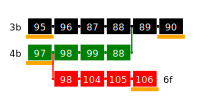

In [38]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 24
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

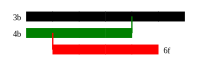

In [39]:
tree.rejected = False
tree.states = []
tree.op = None
tree.from_samples(samps)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.5
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [40]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

import numpy as np

degrees = 180/3.14159

Make sure that all phi/psi values have been computed!

In [41]:
psi = storage.cvs[0]
phi = storage.cvs[1]

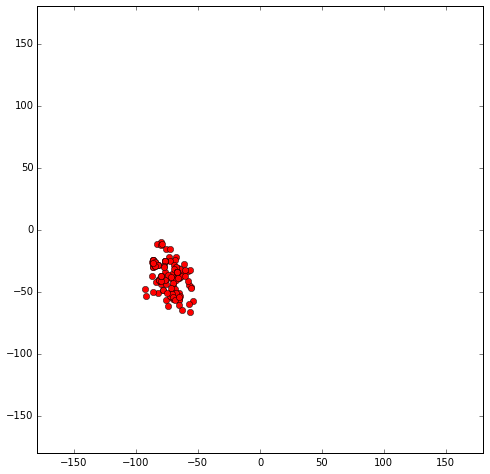

In [42]:
plt.figure(figsize=(8, 8))

for traj in storage.trajectories.iterator():
    phi_angles = degrees * np.array(phi(traj)).flatten()
    psi_angles = degrees * np.array(psi(traj)).flatten()
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

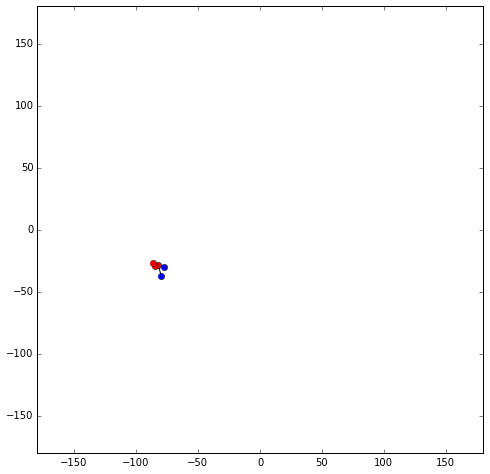

In [43]:
plt.figure(figsize=(8, 8))

traj = storage.trajectories.last
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);

op_notinAorB = storage.cvs[4]

for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

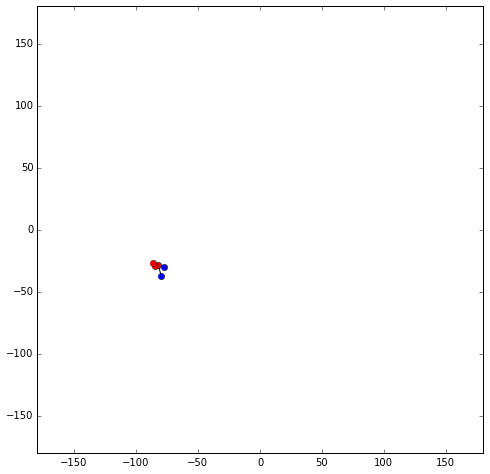

In [44]:
plt.figure(figsize=(8, 8))

traj = storage.samples.last.trajectory
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);


#for snapshot in simulator.storage.snapshot.iterator():
for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);